Shape Recovery from Real Data

# Headers

In [80]:
import numpy as np
import cv2
from ipywidgets import interact, widgets
from IPython.display import display
import torch
import torch.utils.tensorboard as tb
from tqdm import tqdm
import os

import copy
import time
import pickle as pkl
from matplotlib import pyplot as plt
from pytorch3d.renderer import (
    FoVOrthographicCameras, look_at_view_transform,
)

In [81]:
workspace_path = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

import sys
sys.path.append(workspace_path)

import types
from lib.utils import (
    plt_plot_first_nimages,
    temp2counts,
    counts2temp,
    get_perspective_camera,
)
import lib
from lib import runShapeOptimization
import lib.constants as constants

filename = 'real_data_opti'
experiments_file = 'real_experiments_log'
# Set numpy random seed
np.random.seed(42)

In [82]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    # torch.set_default_tensor_type(torch.cuda.DoubleTensor)
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")


# Macros

In [101]:
params_dict = {
    'optimize_MinvL': 0,
    
    'max_img_size': (192, 240),
    # 'start_img_size': (32, 40),
    'start_img_size': (64, 80),
    # 'max_img_size': (256, 320),
    'NUM_BG_FRAMES': 10,
    'NUM_FRAME_DELTA': 10,
    'offset_roi_to_amb': 1,
    'obj_dist': 0.4445, #0.3683,
    'zfar': 0.4845, #0.4762, #0.40,
    'znear': 0.4045, #0.4128, #0.3366,
    'limit_zvals': 0,

    'add_origverts_to_initmesh': 1,
    'ADD_RADIATION': 1,
    'ADD_CONVECTION': 1,
    'use_orthographic_cam_opti': 0,
    
    # Things to optimize for?
    'optim_shape': 1,
    'optim_heat_vals': 1,
    'optim_heat_vals_all_vertices': 1,
    'optim_heat_source': 1,
    'optim_scale_factor': 0,
    'optim_MinvL': 1,
    'optim_heat_capacity': 1,
    'optim_convection_coeff': 1,
    
    'optim_scale_factor': 0,
    'optim_thermal_diff': 0,
    'optim_thermal_cond' : 0,
    
    'normalize_pde_diff': 0,
    'reg_for_optim_MinvL': 0,
    
    # If heating is from a light source, then we can use the shading constraint
    'use_shading_constraint': 1,
    'light_directions': [[50.0, 0.0, 50.0]],
    'use_normal_halfspace_constraint': 1,
    'eps_for_halfspace_const': 0.10,
    
    'save_frame_for_normal_const': 0,
    'use_normal_constraint_from_videos': 0,
    
    'depth_onlyfor_interior': 0,

    'use_image_symmetry_constraint': 1,
    'symmetric_about_axis': 1,

    'init_mesh_from_mask': 1,
    'init_mesh_as_cylindrical': 0,
    'init_mesh_as_spherical': 0,
    
    'heat_mapping_one2one': 1,
    'unproject_and_update': 1,
    'num_views': 1,
    'SURFACE_THICKNESS': 3e-6, #0.0003,  # mm,
    'use_symmetry_for_backside': 0,
    'use_same_mask_for_all_videos': 0,
    'front_back_videos': 0,
    'obj_material': 'polystyrene',
    'num_files': 1,
    'device': device,
    'filename' : filename,
    'obj_name': 'real_data',
    'filter_data': 0,
    'split_final_stage_opti': 1,
    'normal_const_heatmap_ids': [0, 1],
    'workspace_path': workspace_path,
}

params = types.SimpleNamespace(**params_dict)
# Set the focus plane distance
constants.set_focus_distance(params.obj_dist * 1000.0)

FOCUS_DISTANCE set:  444.5


# Load Video

In [103]:

video_filenames = ["bear-v34-0-left-rad1-tlin0-2023-10-16_13-14-39.npz",
                   "bear-v34-1-right-rad1-tlin0-2023-10-16_13-07-11.npz"]


invert_xaxis_vid = False

light_directions = [
    [-0.1439466386421813, -0.44995416229615315, 0.8813742775098354],
    # [-0.17970768255923059, 0.3852157449278193, 0.905159642653657],
]
# video_view_num = [0,0]
video_view_num = [0 for i in range(len(video_filenames))]

video_hs_id = [0, 1, 2, 3]
# light_xhalfspace_loc = [0, 0, -1, 1]
light_xhalfspace_loc = [-1, 1]
params.obj_material = "polystyrene"
light_yhalfspace_loc = [1, -1]


views_azim_angles = [0]
views_elev_angles = [0]

params.use_symmetry_for_backside = 0
params.front_back_videos = 0

##############################################################################################################
# params.SURFACE_THICKNESS = 0.1 #mm
params.num_files = len(video_filenames)
params.num_views = np.unique(video_view_num).shape[0]

params.light_directions = light_directions
params.obj_name = video_filenames[0].split('.')[0]
if params.use_symmetry_for_backside:
    params.num_views = 2


# Marcos
params.K = constants.TDiff[params.obj_material]  # Thermal diffusivity
params.RHO = constants.Density[params.obj_material]
params.C = constants.SpecificHeat[params.obj_material]
params.ABS = constants.Absorptivity[params.obj_material]


AttributeError: 'types.SimpleNamespace' object has no attribute 'opt_MinvL'

## Read Frames

In [108]:
frame_recording = []
bg_recording = []
for video_filename in tqdm(video_filenames):
    if params.optim_MinvL or params.save_frame_for_normal_const:
        if not params.filter_data:
            data = np.load(os.path.join(workspace_path, 'DATA', 'object_study_raw', video_filename), allow_pickle=True)
        else:
            data = np.load(os.path.join(workspace_path, 'DATA', 'obj_study_smooth', video_filename), allow_pickle=True)
        recording = data["frame_recording"]
        if len(recording.shape) == 3:
            recording = recording[np.newaxis]
        del data
        # frame_recording.append(recording[0, params.NUM_BG_FRAMES::params.NUM_FRAME_DELTA])
        # bg_recording.append(recording[0, :params.NUM_BG_FRAMES])
        if not invert_xaxis_vid:
            frame_recording.append(recording[0, params.NUM_BG_FRAMES+10::params.NUM_FRAME_DELTA])
            bg_recording.append(recording[0, params.NUM_BG_FRAMES: params.NUM_BG_FRAMES+10])
        else:
            frame_recording.append(recording[0, params.NUM_BG_FRAMES+10::params.NUM_FRAME_DELTA][:, :, ::-1])
            bg_recording.append(recording[0, params.NUM_BG_FRAMES: params.NUM_BG_FRAMES+10][:, :, ::-1])
        del recording
    else:
        frame_recording.append(np.zeros((1,512,640)))
        bg_recording.append(np.zeros((10,512,640)))
    
min_frames = min([x.shape[0] for x in frame_recording])
frame_recording = [x[:min_frames] for x in frame_recording]
frame_recording = np.array(frame_recording)
bg_recording = np.array(bg_recording)

# Load Mask

100%|████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


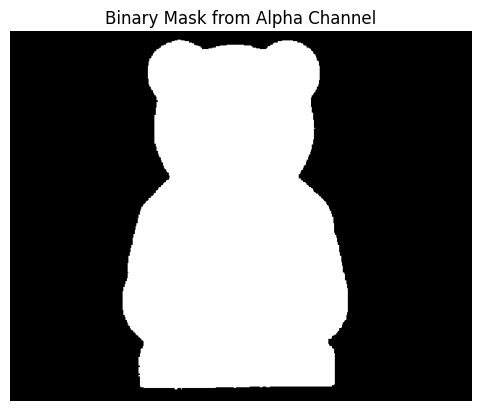

In [109]:
data = np.load(os.path.join(workspace_path, 'DATA', 'object_study_raw', video_filename), allow_pickle=True)
recording = data["frame_recording"][0]


mask = cv2.imread(os.path.join(workspace_path,'image.png'), cv2.IMREAD_UNCHANGED)
mask = mask[:, :, 3]
target_height, target_width = recording.shape[1:3]
resized_mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

binary_mask = (resized_mask > 0).astype(bool)  # Optional: use np.bool_ if needed
# Save as .npy
mask_save_path = os.path.join(workspace_path, 'mask.npy')
np.save(mask_save_path, binary_mask)

plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask from Alpha Channel")
plt.axis('off')
plt.show()

/home/chexu/shape-from-heat/DATA/obj_study_proc/bear-v34-0-left-rad1-tlin0-2023-10-16_13-14-39_mask.png
here
/home/chexu/shape-from-heat/DATA/obj_study_proc/bear-v34-1-right-rad1-tlin0-2023-10-16_13-07-11_mask.png
here


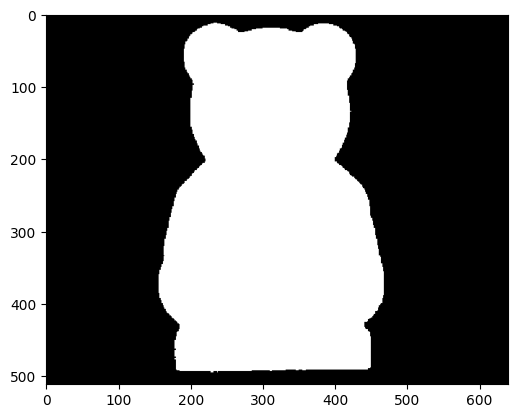

In [78]:
frame_mask = []
for video_filename in video_filenames:
    mask_filename = video_filename.split('.')[0] + '_mask.png'
    mask_filepath = os.path.join(workspace_path, 'DATA', 'obj_study_proc', mask_filename)
    print(mask_filepath)
    png_file = True
    # Check if mask file exists
    # if not os.path.exists(mask_filepath):
    #     mask_filename = video_filename.split('.')[0] + '_mask.pkl'
    #     mask_filepath = os.path.join(workspace_path, 'DATA', 'obj_study_proc', mask_filename)
    #     png_file = False
    try:
        if not png_file:
            print('Loading mask from {}'.format(mask_filepath))
            with open(mask_filepath, 'rb') as f:
                mask_dict = pkl.load(f)
                if not params.use_same_mask_for_all_videos:
                    frame_mask.append(mask_dict['mask'])
                else:
                    frame_mask = [mask_dict['mask']] * len(video_filenames)
                print('Loaded mask with mean {} and stdrange = {}'.format(mask_dict['mean'], mask_dict['stdrange']))
                del mask_dict
        else:
            # mask = cv2.imread(mask_filepath, 0)/255.0
            mask = np.load(os.path.join(workspace_path,'mask.npy'), allow_pickle=True)
            mask = mask.astype(int)
            frame_mask.append(mask)
    except Exception as e:
        print(e)
        continue
frame_mask = np.array(frame_mask)
combined_mask = np.any(frame_mask, axis=0)
plt.imshow(combined_mask, cmap='gray')
plt.show()
view_masks_forobj = np.stack(frame_mask, axis=0).astype(int)
if params.use_symmetry_for_backside:
    flipped_mask = []
    for i in range(view_masks_forobj.shape[0]):
        flipped_mask.append(np.fliplr(view_masks_forobj[i]))
    flipped_mask = np.stack(flipped_mask, axis=0)
    view_masks_forobj = np.concatenate([view_masks_forobj, flipped_mask], axis=0)
view_masks_forobj_pt = torch.tensor(view_masks_forobj).float().to(device)

# Preprocessing

## Ambient Removal

In [110]:
if params.offset_roi_to_amb:

    offset_counts = -np.mean(bg_recording[:, :params.NUM_BG_FRAMES], axis=1, keepdims=True) + temp2counts(constants.AMBIENT_TEMP, constants.CAMERA)
    frame_recording = frame_recording + offset_counts

## Counts to Temperature 

In [111]:
frames_temp = []
for k in range(len(frame_recording)):
    frames_temp_view = []
    for i in tqdm(range(0, frame_recording[k].shape[0], 1)):
        out_temp = counts2temp(frame_recording[k][i].copy(), constants.CAMERA)
        frames_temp_view.append(out_temp)
    frames_temp_view = np.array(frames_temp_view)
    frames_temp.append(frames_temp_view)
frames_temp = np.array(frames_temp)

if params.use_symmetry_for_backside:
    all_back_videos = []
    for i in range(frames_temp.shape[0]):
        back_video = []
        for j in range(frames_temp.shape[1]):
            back_video.append(cv2.flip(frames_temp[i, j], 1))
        back_video = np.array(back_video)
        all_back_videos.append(back_video)
    all_back_videos = np.array(all_back_videos)
    frames_temp = np.concatenate((frames_temp, all_back_videos), axis=0)
    del back_video

del frame_recording

100%|█████████████████████████████████████████████| 90/90 [00:00<00:00, 183.63it/s]


In [112]:
print(frames_temp.shape, view_masks_forobj.shape)

(2, 90, 512, 640) (2, 512, 640)


## Vis Mask Over Frames

(2, 90, 512, 640)
(2, 90, 512, 640)


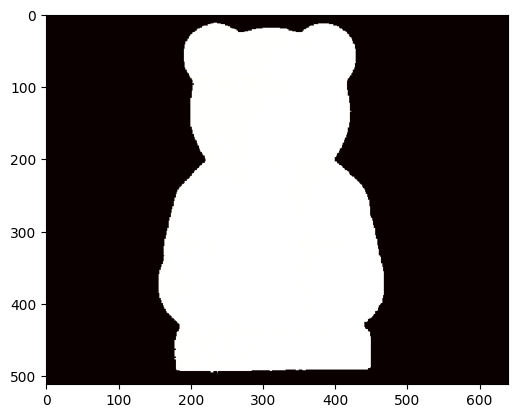

interactive(children=(IntSlider(value=0, description='val', max=89), Output()), _dom_classes=('widget-interact…

<function __main__.update(val)>

In [123]:
plt.close('all')
fig = plt.figure()
# Use a slider and plot heat flow at different time steps for u_real_pixels_msize using matplotlib
# Update matplotlib plot with new heat values based on slider value
ax = fig.add_subplot(1, 1, 1)
print(frames_temp.shape)
ax.imshow(frames_temp[-1,0]*view_masks_forobj[-1], cmap='hot')

vindx = np.where(view_masks_forobj[-1])
vmin = np.min(frames_temp[:, :, vindx[0], vindx[1]])
vmax = np.max(frames_temp[:, :, vindx[0], vindx[1]])
def update(val):
    ax.clear()
    ax.imshow(frames_temp[-1, int(val)]*view_masks_forobj[-1], cmap='hot', vmin=vmin, vmax=vmax)
    # ax.imshow(frames_temp[0, int(val)], cmap='hot')
    # ax.set_title('Heat flow at t = {}, \n min-temp={:.2f} max-temp={:.2f}'.format(int(val), vmin, vmax))
    ax.set_title('Heat flow at t = {}, \n min-temp={:.2f} max-temp={:.2f}'.format(int(val), np.min(frames_temp[0, int(val), vindx[0], vindx[1]]), np.max(frames_temp[0, int(val), vindx[0], vindx[1]])))
    ax.axis('off')
    fig.canvas.draw()
    display(fig)

print(frames_temp.shape)

interact(update, val=widgets.IntSlider(min=0, max=frames_temp.shape[1]-1, step=1, value=0))

In [124]:
FRAME_START = None
FRAME_END = None
if FRAME_START is not None or FRAME_END is not None:
    frames_temp = frames_temp[:, FRAME_START:FRAME_END]

In [125]:
shading_params = {
    "width": 600, "height": 600,
    "antialias": True,
    "colormap": "viridis",
    "wireframe": False, "wire_width": 0.03, "wire_color": "black"
}

### Render N views

In [126]:
with torch.no_grad():
    
    # Get a batch of viewing angles. 
    elev = torch.from_numpy(np.array(views_elev_angles)).to(dtype=torch.float, device=device)
    azim = torch.from_numpy(np.array(views_azim_angles)).to(dtype=torch.float, device=device)
        
    if params.use_symmetry_for_backside or params.front_back_videos:
        views_elev_angles = np.concatenate([np.array(views_elev_angles), np.array(views_elev_angles)], axis=0)
        views_azim_angles = np.concatenate([np.array(views_azim_angles), np.array(views_azim_angles) + 180], axis=0)
        elev = torch.from_numpy(np.array(views_elev_angles)).to(dtype=torch.float, device=device)
        azim = torch.from_numpy(np.array(views_azim_angles)).to(dtype=torch.float, device=device)


    print(elev, azim)
    R, T = look_at_view_transform(dist=params.obj_dist, elev=elev, azim=azim, device=device, degrees=True)
    if params.use_orthographic_cam_opti:
        cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=params.znear, zfar=params.zfar)
    else:
        cameras = get_perspective_camera(params.start_img_size, constants.HFOV, constants.VFOV, R, T, device)
        

    print(cameras.get_camera_center())

tensor([0.]) tensor([0.])
tensor([[0.0000, 0.0000, 0.4445]])


# Optimization

## Laplacian-Opti Macros

In [127]:
Lopti_params_dict = {
    "num_iterations": 20000, #10000  # Number of optimization steps
    "learning_rate": 1e-2,  # Step size
    # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)
    "lambda_": 19,
    "lambda_pde": 1.0,
    "lambda_heat_reg": 1.0,#1e-2, #1.0,
    "lr_step_size": 7000,
    "lr_gamma": 0.5,
    "min_theta": np.radians(0.0),
    "max_theta": np.radians(180.0),
    "add_gaussian_curv_smoothing": 0,
    "lambda_gcurv": 1e-3,
    "min_edge_length": 0.0001,
}

Lopti_params = types.SimpleNamespace(**Lopti_params_dict)

## Shape-Opti Macros

In [128]:
Sopti_params_dict = {
    "num_iterations": 2600, #45*20, #50*20, #25*20, #45*20, #45*20, #45*20, #2600, #10000  # Number of optimization steps
    "lambda_sdotn": 0.0,

    "learning_rate": 1e-2,  # Step size
    # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)
    "lambda_": 5,
    "lambda_pde": 1.0,
    "add_willmore_loss": 0,
    "willmore_reg": 1.0, #1e3,
    "lambda_MinvLreg": 0.1,
    "reduce_willmore_lambda": 1,
    "reduce_willmore_steps": 1000,
    "mesh_edge_reg": 0.0,
    "normal_reg": 0.01,  # 10.0 #0.2 #10.0
    "laplacian_reg": 0.0, #0.5,  # 10 # 1.0
    "lambda_heat_reg": 1.0,
    "lambda_curv_sign": 1.0,
    "lambda_normal_halfspace": 10.0, # 1e-3,
    "num_steps_for_halfspace_const": -1, #3000,
    "reduce_normal_halfspace_lambda": 1,
    "reduce_normal_halfspace_steps": 100,
    
    "toggle_halfspace_const": 0,
    "toggle_halfspace_const_steps": 1000,

    "boundary_normal_const": 0,
    "invert_boundary_normal_dir": 0,
    "lambda_boundary_normal": 1e-8,

    "lr_step_size": 7000,
    "lr_gamma": 0.5,
    "heat_source_opti": 0,
    "heat_value_opti": 0,
    "heat_capacity_opti": 0,
    "convection_coeff_opti": 0,

    "reduce_diffusivity": 0,
    "opti_close_to_init_mesh": 0,
    "lambda_reg_init_mesh": 1.0,
    "lambda_symmetric_verts": 1e4,
    "num_steps_for_symmetric_verts": 1000,
    "lambda_normal_flipping": 1.0,
    "activate_normal_reg_after_step": 2000,
    "activate_laplacian_reg_after_step": 500,

    'pre_final_stage_sizes': [], #[(32, 40), (64,80)],
    'pre_final_stage_iterations': [1000] #[86*20], #[114*20], #[40], #[4*20], #[40],
    
}

Sopti_params = types.SimpleNamespace(**Sopti_params_dict)

## Exp-name

In [129]:
exp_name = video_filenames[0].split('.')[0]
experiment = {}
experiment['Filename'] = filename
experiment['Exp-name'] = exp_name

# Add all variables in params and Sopti_params classes to experiment
for k, v in params.__dict__.items():
    if type(v) in [int, float] and not k.startswith('__'):
        experiment[k] = v

for k, v in Sopti_params.__dict__.items():
    if type(v) in [int, float] and not k.startswith('__'):
        experiment['Sopti-'+k] = v


exp_name += '-test-v1'
# exp_name += '-beforeconf-wheatsource-v12'
print(exp_name)

bear-v34-0-left-rad1-tlin0-2023-10-16_13-14-39-test-v1


## Run Optimization

Current image size: (64, 80), stage num: 0


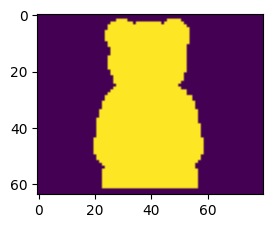

AttributeError: module 'pymesh' has no attribute 'form_mesh'

In [131]:
writer = tb.SummaryWriter(log_dir=os.path.join(workspace_path, 'tb-logs', filename, exp_name))

light_xyhalfspace_loc = [light_xhalfspace_loc, light_yhalfspace_loc]

runShapeOptimization(video_filenames[0].split('.')[0], params, R, T, view_masks_forobj, frames_temp, Lopti_params, Sopti_params, writer, filename, exp_name, light_xyhalfspace_loc)

writer.close()
